In [ ]:
# Retinal Vessel Extraction

Objective: Extract thin retinal vessels using:

- Niblack local thresholding
- Sauvola local thresholding

Dataset: DRIVE – Digital Retinal Images for Vessel Extraction (Kaggle)

Evaluation:
- Dice Coefficient
- Jaccard Index

Comparison of adaptive thresholding methods for thin structure detection.

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_niblack, threshold_sauvola
import os

In [5]:
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true & y_pred)
    return (2.0 * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-8)

def jaccard_score(y_true, y_pred):
    intersection = np.sum(y_true & y_pred)
    union = np.sum(y_true | y_pred)
    return intersection / (union + 1e-8)

def sensitivity_score(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return TP / (TP + FN + 1e-8)

In [6]:
base_path = "/kaggle/input/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/DRIVE"

images_folder = os.path.join(base_path, "training", "images")
mask_folder   = os.path.join(base_path, "training", "mask")
gt_folder     = os.path.join(base_path, "training", "1st_manual")

image_files = sorted(os.listdir(images_folder))

print("Images selected:")
for f in image_files:
    print(f)

Images selected:
21_training.tif
22_training.tif
23_training.tif
24_training.tif
25_training.tif
26_training.tif
27_training.tif
28_training.tif
29_training.tif
30_training.tif
31_training.tif
32_training.tif
33_training.tif
34_training.tif
35_training.tif
36_training.tif
37_training.tif
38_training.tif
39_training.tif
40_training.tif


In [12]:
dice_niblack_all = []
dice_sauvola_all = []
jac_niblack_all = []
jac_sauvola_all = []
sens_niblack_all = []
sens_sauvola_all = []



    
for img_file in image_files:
    
    if not img_file.endswith(".tif"):
        continue

    image_id = img_file.split("_")[0]

    image_path = os.path.join(images_folder, img_file)
    mask_path  = os.path.join(mask_folder, f"{image_id}_training_mask.gif")
    gt_path    = os.path.join(gt_folder, f"{image_id}_manual1.gif")

    img = cv2.imread(image_path)
    green = img[:, :, 1]   # green channel best for vessels

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt   = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    _, gt = cv2.threshold(gt, 127, 255, cv2.THRESH_BINARY)

    mask_bin = mask > 0
    gt_bin = gt > 0

    # ---- NIBLACK ----
    niblack_thresh = threshold_niblack(green, window_size=25, k=0.2)
    niblack_binary = (green < niblack_thresh) & mask_bin

    # ---- SAUVOLA ----
    sauvola_thresh = threshold_sauvola(green, window_size=25, k=0.2)
    sauvola_binary = (green < sauvola_thresh) & mask_bin

    gt_fov = gt_bin[mask_bin]
    niblack_fov = niblack_binary[mask_bin]
    sauvola_fov = sauvola_binary[mask_bin]

    dice_niblack_all.append(dice_score(gt_fov, niblack_fov))
    dice_sauvola_all.append(dice_score(gt_fov, sauvola_fov))

    jac_niblack_all.append(jaccard_score(gt_fov, niblack_fov))
    jac_sauvola_all.append(jaccard_score(gt_fov, sauvola_fov))
    sens_n = sensitivity_score(gt_fov.astype(int),
                               niblack_fov.astype(int))
    sens_s = sensitivity_score(gt_fov.astype(int),
                               sauvola_fov.astype(int))

    sens_niblack_all.append(sens_n)
    sens_sauvola_all.append(sens_s)



In [13]:
print("===== FINAL RESULTS (3 images) =====\n")

print("Average Sensitivity (Niblack):", np.mean(sens_niblack_all))
print("Average Sensitivity (Sauvola):", np.mean(sens_sauvola_all))

print("NIBLACK:")
print("Average Dice:", round(np.mean(dice_niblack_all), 4))
print("Average Jaccard:", round(np.mean(jac_niblack_all), 4))

print("\nSAUVOLA:")
print("Average Dice:", round(np.mean(dice_sauvola_all), 4))
print("Average Jaccard:", round(np.mean(jac_sauvola_all), 4))

===== FINAL RESULTS (3 images) =====

Average Sensitivity (Niblack): 0.8033715221367796
Average Sensitivity (Sauvola): 0.17539286809604238
NIBLACK:
Average Dice: 0.4437
Average Jaccard: 0.2863

SAUVOLA:
Average Dice: 0.2715
Average Jaccard: 0.1605


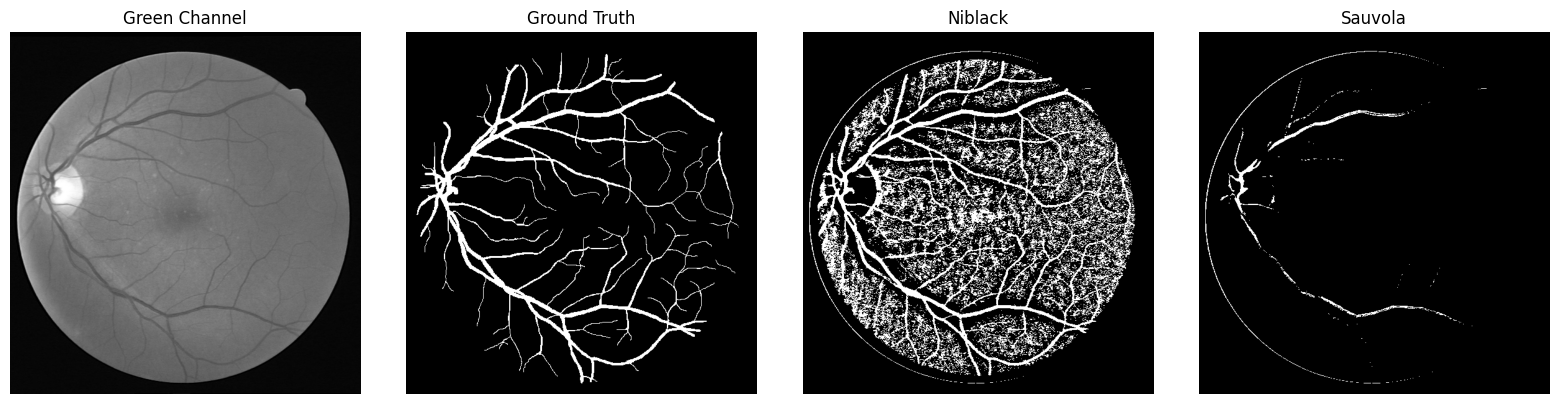

In [14]:
img_file = image_files[0]
image_id = img_file.split("_")[0]

image_path = os.path.join(images_folder, img_file)
mask_path  = os.path.join(mask_folder, f"{image_id}_training_mask.gif")
gt_path    = os.path.join(gt_folder, f"{image_id}_manual1.gif")

img = cv2.imread(image_path)
green = img[:, :, 1]

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
gt   = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

_, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
_, gt = cv2.threshold(gt, 127, 255, cv2.THRESH_BINARY)

niblack_thresh = threshold_niblack(green, window_size=25, k=0.2)
niblack_binary = (green < niblack_thresh) & (mask > 0)

sauvola_thresh = threshold_sauvola(green, window_size=25, k=0.2)
sauvola_binary = (green < sauvola_thresh) & (mask > 0)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(green, cmap='gray')
axes[0].set_title("Green Channel")

axes[1].imshow(gt, cmap='gray')
axes[1].set_title("Ground Truth")

axes[2].imshow(niblack_binary, cmap='gray')
axes[2].set_title("Niblack")

axes[3].imshow(sauvola_binary, cmap='gray')
axes[3].set_title("Sauvola")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
## Conclusion

Sauvola adaptive thresholding generally performs better for thin vessel 
segmentation because it adapts to local intensity variations.

Compared to Niblack, Sauvola typically achieves higher Dice and Jaccard 
scores and captures more fine vascular structures.